<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Pyosim in the cloud
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |

# Inverse kinematics

In [1]:
from pathlib import Path

import yaml

import numpy as np
import pandas as pd
from pyosim import Conf
from pyomeca import Analogs3d

import altair as alt

alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

In [2]:
MODEL = "wu"
DATA = '2_inverse_dynamic'
EXT = 'sto'

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
participants = conf.get_participants_to_process()
conf.check_confs()

Project loaded
Configuration file loaded


sarc: checked
sarc: updated in project conf
inea: checked
inea: updated in project conf
dapo: checked
dapo: updated in project conf
laug: checked
laug: updated in project conf
mara: checked
mara: updated in project conf
mars: checked
mars: updated in project conf
yosc: checked
yosc: updated in project conf
marc: checked
marc: updated in project conf
benl: checked
benl: updated in project conf
davo: checked
davo: updated in project conf
marb: checked
marb: updated in project conf
gatb: checked
gatb: updated in project conf
yoap: checked
yoap: updated in project conf
romm: checked
romm: updated in project conf




In [4]:
data = []
for iparticipant in participants:
    data_path = conf.project_path / iparticipant / DATA
    for ifile in data_path.glob(f"*.{EXT}"):
        f = ifile.stem.replace(f"{MODEL}_", "")
        meta = {
            "filename": ifile.stem,
            "participant": f[:4].lower(),
            "sex": f[4],
            "height": f[-3],
            "weight": f[5:].split("H")[0],
            "trial": f[-1],
        }
        d = Analogs3d.from_sto(ifile)
        data.append(
#             d.low_pass(freq=d.get_rate, order=4, cutoff=10)
            d.moving_average(20)
            .time_normalization()
            .update_misc(meta)
            .to_dataframe(add_metadata=["misc"])
        )
data = pd.concat(data).reset_index()

print(data.shape)
data.head()

/home/romain/miniconda3/envs/pyosim_aws/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/romain/miniconda3/envs/pyosim_aws/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/romain/miniconda3/envs/pyosim_aws/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inst

(10302, 32)


,index,thorax_tilt_moment,thorax_list_moment,thorax_rotation_moment,thorax_tx_force,thorax_ty_force,thorax_tz_force,box_rotX_moment,box_rotY_moment,box_rotZ_moment,...,elbow_flexion_moment,pro_sup_moment,hand_r_Add_moment,hand_r_Flex_moment,filename,participant,sex,height,weight,trial
0,0,63.766066,11.367352,-3.504485,-0.098077,383.262401,-1.358051,0.144995,-0.000244,0.084856,...,2.371791,-0.192971,0.228074,-0.322129,wu_SarCF6H2_3,sarc,F,2,6,3
1,1,65.729926,11.644751,-4.183112,-9.856753,384.981687,1.168670,0.147480,0.006296,0.084458,...,2.771084,-0.170140,-0.123584,-0.132510,wu_SarCF6H2_3,sarc,F,2,6,3
2,2,67.285001,12.091748,-4.853400,-18.137673,386.813360,3.863295,0.149943,0.012845,0.084051,...,3.177726,-0.150970,-0.467110,0.053572,wu_SarCF6H2_3,sarc,F,2,6,3
3,3,68.612232,12.800038,-5.492019,-25.054294,389.275639,6.825112,0.152458,0.019405,0.083681,...,3.596863,-0.138615,-0.795348,0.229879,wu_SarCF6H2_3,sarc,F,2,6,3
4,4,70.422019,13.626594,-6.088537,-32.010178,393.183125,9.812788,0.155180,0.025837,0.083475,...,4.036426,-0.131983,-1.097960,0.393399,wu_SarCF6H2_3,sarc,F,2,6,3


In [5]:
data_wide = data.melt(id_vars=["index", "filename", "participant", "sex", "height", "weight", "trial"])
data_wide.head()

,index,filename,participant,sex,height,weight,trial,variable,value
0,0,wu_SarCF6H2_3,sarc,F,2,6,3,thorax_tilt_moment,63.766066
1,1,wu_SarCF6H2_3,sarc,F,2,6,3,thorax_tilt_moment,65.729926
2,2,wu_SarCF6H2_3,sarc,F,2,6,3,thorax_tilt_moment,67.285001
3,3,wu_SarCF6H2_3,sarc,F,2,6,3,thorax_tilt_moment,68.612232
4,4,wu_SarCF6H2_3,sarc,F,2,6,3,thorax_tilt_moment,70.422019


In [6]:
d.get_labels

['thorax_tilt_moment',
 'thorax_list_moment',
 'thorax_rotation_moment',
 'thorax_tx_force',
 'thorax_ty_force',
 'thorax_tz_force',
 'box_rotX_moment',
 'box_rotY_moment',
 'box_rotZ_moment',
 'box_transX_force',
 'box_transY_force',
 'box_transZ_force',
 'sternoclavicular_r1_moment',
 'sternoclavicular_r2_moment',
 'sternoclavicular_r3_moment',
 'Acromioclavicular_r1_moment',
 'Acromioclavicular_r2_moment',
 'Acromioclavicular_r3_moment',
 'shoulder_plane_moment',
 'shoulder_ele_moment',
 'shoulder_rotation_moment',
 'elbow_flexion_moment',
 'pro_sup_moment',
 'hand_r_Add_moment',
 'hand_r_Flex_moment']

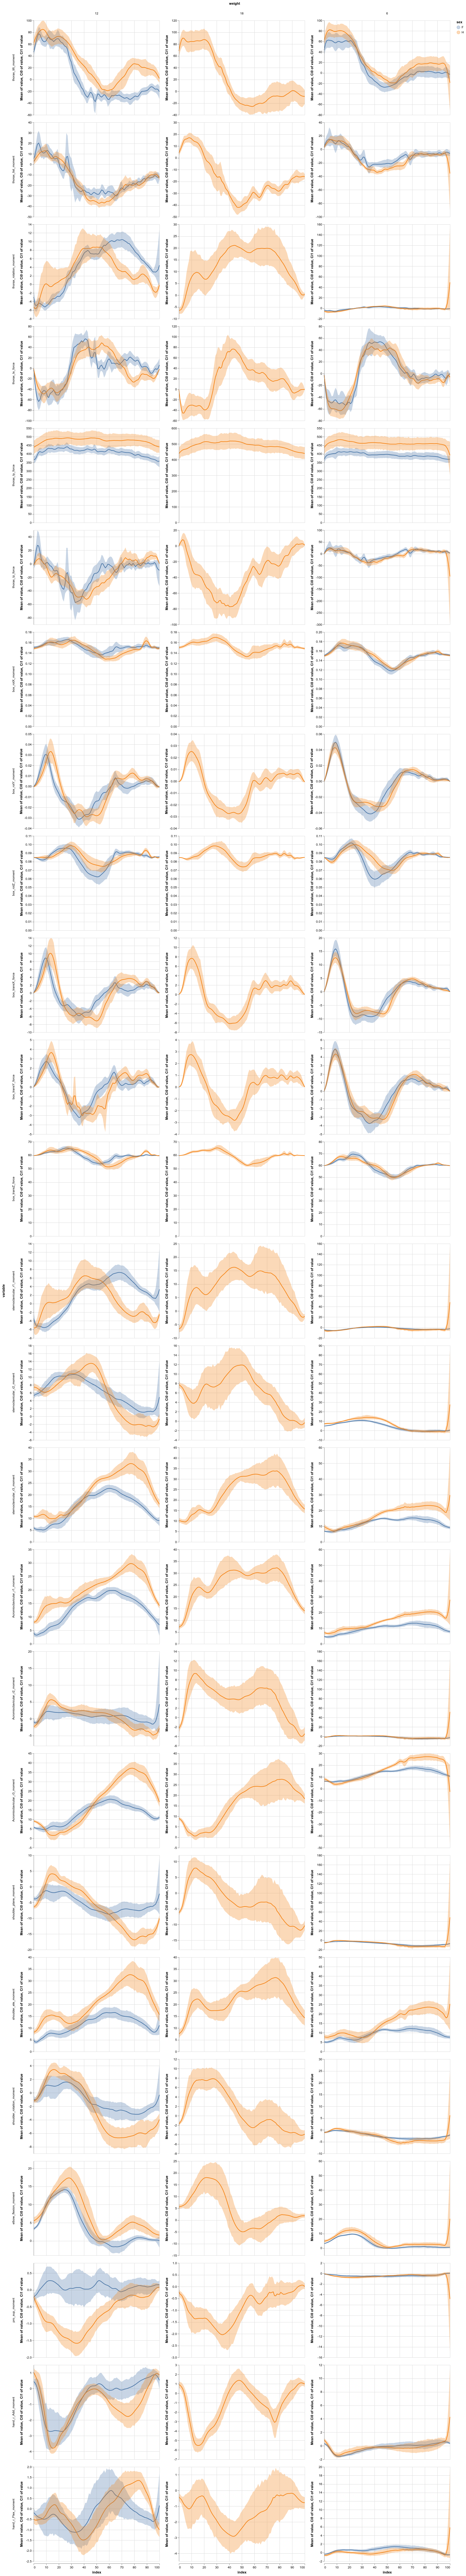

In [8]:
line = (
    alt.Chart()
    .mark_line()
    .encode(alt.X("index"), alt.Y("mean(value)"), alt.Color("sex"))
)

area = (
    alt.Chart()
    .mark_area(opacity=0.3)
    .encode(alt.X("index"), alt.Y("ci0(value)"), alt.Y2("ci1(value)"), alt.Color("sex"))
)

(line + area).facet(
    data=data_wide,
    column=alt.Column("weight"),
    row=alt.Row("variable", sort=alt.Sort(d.get_labels)),
).resolve_scale(y="independent")

In [9]:
# for iparticipant in participants:
#     data_path = conf.project_path / iparticipant / "1_inverse_kinematic"
#     for ifile in data_path.glob("*"):
#         ifile.unlink()
#         print(ifile)
# #         if ifile.stem[-3] != "2" and f[-2:] != "d0":
# #             ifile.unlink()
# #             print(ifile)
# #         else:
# #             print("safe")

<!--NAVIGATION-->
< [Raw data](01.01-raw-data.ipynb) | [Contents](Index.ipynb) |